<a href="https://colab.research.google.com/github/ducnguyy/code/blob/master/Group_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
### Import packages


In [ ]:
import pdb
import gc

In [ ]:
#importing necessary packages for image processing
from __future__ import print_function, division
import os

import torch
from torch import nn
import torchvision
from torchvision import transforms, utils
import torchvision.transforms as T
import torch.nn.functional as F

import PIL
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR100
from tqdm import tqdm
from sklearn.metrics import f1_score,roc_auc_score

from sklearn.utils import compute_class_weight

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

---
### Create the pipeline

Define functions to separate & merge data into in-use training dataset:

In [ ]:
def create_superclass_labels_based_set(x):
    set=[]
    for i in range(len(superclass_label)):
        if superclass_label[i]==x:
            set.append(i)
    return set
def create_class_labels_based_set(x):
    set=[]
    for i in range(len(class_label)):
        if class_label[i]==x:
            set.append(i)
    return set
def divide_and_merge_class_labels_set(x,y,p):
    get_num_set1=len(x)
    get_num_set2=len(y)
    total_num_instances=get_num_set1+get_num_set2
    separate_milestone=round(total_num_instances*p)
    separate_x=x[:separate_milestone] 
    separate_y=y[separate_milestone:] 
    return separate_x+separate_y
def find_class_name(dataset,index_x):
    return class_name[class_label[dataset[index_x]]]
def find_superclass_name(dataset,index_x):
    return superclass_name[superclass_label[dataset[index_x]]]
def find_class_label(dataset,index_x):
    return class_label[dataset[index_x]]
def find_superclass_label(dataset,index_x):
    return superclass_label[dataset[index_x]]
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# Unwrap training data and transform it:



In [ ]:
cifar_train = CIFAR100(os.getcwd(), download= True, transform=transform)
cifar_test = CIFAR100(os.getcwd(), train = False, transform=transform)

test_data = unpickle('cifar-100-python/test')
meta_data = unpickle('cifar-100-python/meta')
train_data = unpickle('cifar-100-python/train')

X_train=train_data[b'data']
X_train = X_train.reshape(len(X_train),3,32,32)
X_train = X_train.transpose(0,2,3,1)
X_test=test_data[b'data']
X_test = X_test.reshape(len(X_test),3,32,32)
X_test = X_test.transpose(0,2,3,1)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting /content/cifar-100-python.tar.gz to /content


# Create a class for Dataset with 3 initial functions: init, len, getitem

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X,label_set,dataset_name):
        self.X=X 
        self.labels=np.array([])
        self.super_labels=np.array([])
        self.label_set=label_set 
        self.name=dataset_name
        for example in range(self.X.shape[0]):
          #create label set based on classes
          if self.name == "household":
            if superclass_label[self.label_set[example]]==5:
                self.labels=np.append(self.labels,[1])
            elif superclass_label[self.label_set[example]]==6:
                self.labels=np.append(self.labels,[0]) 
          elif self.name == "tree_1":
            if class_label[self.label_set[example]]==47:
                self.labels=np.append(self.labels,[1])
            elif class_label[self.label_set[example]]==52:
                self.labels=np.append(self.labels,[0]) 
          elif self.name == "tree_2":
            if class_label[self.label_set[example]]==56:
                self.labels=np.append(self.labels,[1])
            elif class_label[self.label_set[example]]==52:
                self.labels=np.append(self.labels,[0])
    def __len__(self):
        return len(self.labels)
    def __getitem__(self,ID):
        label_of_img = self.labels[ID]
        img_true=self.X[ID]
        #this is the transforming step done from scratch
        img_true=np.array(img_true)
        img_true=img_true.astype("float64")
        img_true/=255
        label_of_img=np.array(label_of_img)
        img_true=torch.from_numpy(img_true)
        img_true=img_true.permute(2,0,1)
        label_of_img=torch.from_numpy(label_of_img)
        return img_true, label_of_img

(*)Define architectures of our model:

Since the paper doesn't specify rigidly the activation functions in each layer, here we used the commonly choice of activation function: ReLU(). In the final layer, we used Sigmoid which is specified in the paper.  

In [ ]:
class CustomModel(nn.Module):
    def __init__(self,dataset_name):
        super(CustomModel,self).__init__()
        self.name=dataset_name
        self.Flatten=nn.Flatten()
        if self.name == "household":
          self.features = nn.Sequential(
              nn.Linear(in_features = 3072, out_features = 1000),
              nn.ReLU(),
              nn.Linear(in_features = 1000, out_features = 300),
              nn.ReLU(),
              nn.Linear(in_features = 300, out_features = 100),
              nn.ReLU()
          )
          self.logit = nn.Sequential(
              nn.Linear(in_features = 100, out_features = 1)
          )
          self.output = nn.Sequential(            
              nn.Sigmoid()
          )
        elif self.name == "tree_1" or "tree_2":
          self.features=nn.Sequential(
            nn.Linear(in_features=3072,out_features=1000),
            nn.ReLU(),
            nn.Linear(in_features=1000,out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100,out_features=10),
            nn.ReLU()
          )
          self.logit = nn.Sequential(
              nn.Linear(in_features = 10, out_features = 1)
          )
          self.output = nn.Sequential(
              nn.Sigmoid()
          )
    def forward(self,x):
        x = self.Flatten(x)
        features = self.features(x)
        logit = self.logit(features)
        output = self.output(logit)
        return features, logit, output

#Define loss criterion: here we compare between Mean Squared Error, Binary Cross Entropy Loss, MFE(self-implement), MSFE(self-implement), Focal Loss, Weighted Cross Entropy Loss. 

In [ ]:
#with mse/mfe/msfe we have output = output, target = target 
#with focal loss, we use both probs & output 

def MSE(output, target):
  loss = ((1/2) * ((output - target) ** 2)).mean()
  return loss

def MFE(output, target):
    pred_1 = []
    true_1 = []
    pred_2 = []
    true_2 = []
    for i in range(target.size(dim = 0)):
      #minority and positive class
      if target[i] == 1:
        pred_1.append(output[i])
        true_1.append(target[i])
      else:
      #majority and negative class
        pred_2.append(output[i])
        true_2.append(target[i])
    if len(pred_1) == 0:
      pred_2 = torch.cat(pred_2, dim = 0)
      true_2 = torch.cat(true_2, dim = 0)
      loss_ret = MSE(pred_2, true_2) #FPE
    elif len(pred_2) == 0:
      pred_1 = torch.cat(pred_1, dim = 0)
      true_1 = torch.cat(true_1, dim = 0)
      loss_ret = MSE(pred_1, true_1) #FNE
    else:
      pred_1 = torch.cat(pred_1, dim = 0)
      true_1 = torch.cat(true_1, dim = 0)
      pred_2 = torch.cat(pred_2, dim = 0)
      true_2 = torch.cat(true_2, dim = 0)
      loss_ret = MSE(pred_2, true_2) + MSE(pred_1, true_1)
    return loss_ret

def MSFE(output,target):
    pred_1 = []
    true_1 = []
    pred_2 = []
    true_2 = []
    for i in range(target.size(dim = 0)):
      if target[i] == 1:
        pred_1.append(output[i])
        true_1.append(target[i])
      else:
        pred_2.append(output[i])
        true_2.append(target[i])
    if len(pred_1) == 0:
      pred_2 = torch.cat(pred_2, dim = 0)
      true_2 = torch.cat(true_2, dim = 0)
      FPE = MSE(pred_2,true_2)
      loss_ret2 = 1/2* ( (FPE ** 2) + (FPE ** 2))
    elif len(pred_2) == 0:
      pred_1 = torch.cat(pred_1, dim = 0)
      true_1 = torch.cat(true_1, dim = 0)
      FNE = MSE(pred_1,true_1)
      loss_ret2 = 1/2 * ( (FNE ** 2) + (( - FNE) ** 2))
    else:
      pred_1 = torch.cat(pred_1, dim = 0)
      true_1 = torch.cat(true_1, dim = 0)
      pred_2 = torch.cat(pred_2, dim = 0)
      true_2 = torch.cat(true_2, dim = 0)
      FPE = MSE(pred_2, true_2)
      FNE = MSE(pred_1, true_1)
      loss_ret2 = (1/2) * (((FPE + FNE) ** 2) + ((FPE - FNE) ** 2))
    return loss_ret2

def sigmoid_focal_loss(inputs, targets, alpha: float = 0.25, gamma: float = 2):
   """
   Loss used in RetinaNet for dense detection: https://arxiv.org/abs/1708.02002.
   Args:
       inputs: A float tensor of arbitrary shape.
               The predictions for each example.
       targets: A float tensor with the same shape as inputs. Stores the binary
                classification label for each element in inputs
               (0 for the negative class and 1 for the positive class).
       alpha: (optional) Weighting factor in range (0,1) to balance
               positive vs negative examples. Default = -1 (no weighting).
       gamma: Exponent of the modulating factor (1 - p_t) to
              balance easy vs hard examples.
   Returns:
       Loss tensor
   """
   prob = inputs.sigmoid()
   ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
   p_t = prob * targets + (1 - prob) * (1 - targets)
   loss = ce_loss * ((1 - p_t) ** gamma)
    

   if alpha >= 0:
       alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
       loss = alpha_t * loss


   return loss.mean()


# Making in-use dataset:

Step 1: create a set consisted of class labels.
 
Parameter: p in [0,1]; p = Imb.Level 


In [ ]:
def test_image(ID_test, dataset_name):
  ID_test = 300
  image = X_operator[ID_test]
  if dataset_name == "tree_1":
    plt.imshow(image) 
    plt.title("Coarse Label Name:{} \n Fine Label Name:{}"
            .format(superclass_name[superclass_label[tree_1[ID_test]]], class_name[class_label[tree_1[ID_test]]]))
    plt.show()
  elif dataset_name == "tree_2":
    plt.imshow(image) 
    plt.title("Coarse Label Name:{} \n Fine Label Name:{}"
            .format(superclass_name[superclass_label[tree_2[ID_test]]], class_name[class_label[tree_2[ID_test]]]))
    plt.show()
  else:
    plt.imshow(image) 
    plt.title("Coarse Label Name:{} \n Fine Label Name:{}"
            .format(superclass_name[superclass_label[household[ID_test]]], class_name[class_label[household[ID_test]]]))
    plt.show()

In [ ]:
#shape: 
  #household : 2500 - 32 - 32 - 3; 
  #tree: 500 - 32 - 32 - 3;

Step 2: Create X_operator, which is the semi-final step of making in-use training dataset.

Distinguish it with X_train which includes not only data but also labels.

Change computing location from CPU to GPU if available:

In [ ]:
def set_computing_location():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  print(f"Using {device} device")
  return device

device = set_computing_location()

Using cuda device


#Visualizing function:

In [ ]:
def plotting(epochs, mean_loss, mean_f1, mean_auc, mean_accs):
  n=[]
  for i in range(epochs):
    n=np.append(n,i)
  #print(mean_loss)
#   f = plt.figure()
#   f.set_figwidth(10)
#   f.set_figheight(7.5)
  plt.xlabel("Epoch")
  plt.ylabel("Mean Loss")
  plt.plot(n, mean_loss)
  plt.title("Loss regressed over epochs")
  plt.show()
  #if the plot come out weird -> not a problem! It's because value of both regress up or down while training!
  #plt.plot(mean_loss, mean_f1)
  #plt.xlabel("Mean Loss")
  #plt.ylabel("Mean F1 score")
  #plt.title("Mean Loss vs Mean F1 score")
  #plt.show()

  plt.plot(n, mean_accs)
  plt.xlabel("Epoch")
  plt.ylabel("Mean Accuracy")
  plt.title("Accuracy over epochs")
  plt.show()

  #plt.plot(mean_loss, mean_auc)
  #plt.xlabel("Mean Loss")
  #plt.ylabel("Mean ROC-AUC score")
  #plt.title("Mean Loss vs Mean ROC-AUC score")
  #plt.show()


Now train the model and making evaluation points:
Here we use loss, accuracy, f-1 score, AUC score.
NOTE: .to(device) is for running with available gpu, and is disabled by default. But run it in your machine pls.

In [ ]:
def set_pipeline(X_train, dataset_name, imb_level, learning_rate, num_of_epochs, batch_size_train, shuffle_train, loss_name):

#-------------------------------------------------------------------------------
  house_device_set = create_superclass_labels_based_set(5)
  furniture = create_superclass_labels_based_set(6)
  household = divide_and_merge_class_labels_set(house_device_set, furniture, p = imb_level)

  maple_tree = create_class_labels_based_set(47)
  oak_tree = create_class_labels_based_set(52)
  tree_1 = divide_and_merge_class_labels_set(maple_tree, oak_tree, p = imb_level)

  palm_tree = create_class_labels_based_set(56)
  oak_tree = create_class_labels_based_set(52)
  tree_2 = divide_and_merge_class_labels_set(palm_tree, oak_tree, p = imb_level)
#-------------------------------------------------------------------------------
  if dataset_name == "tree_1":
    X_operator = X_train[tree_1]
    label = tree_1
  elif dataset_name == "tree_2":
    X_operator = X_train[tree_2]
    label = tree_2
  elif dataset_name == "household":
    X_operator = X_train[household]
    label = household
  else:
    print("Undefined Dataset.")
  print(f"TRAINING SET'S: \n Number of instance:",X_operator.shape[0])
#-------------------------------------------------------------------------------
  #device = set_computing_location().lower()
  #Final step: making Dataset object and Dataloader:
  CIFAR_operator = CustomDataset(X = X_operator, label_set = label, dataset_name = dataset_name)
  Custom_DataLoader = torch.utils.data.DataLoader(CIFAR_operator, batch_size = batch_size_train, shuffle = shuffle_train, num_workers = 2)
  model = CustomModel(dataset_name).float()#.to(device)
  #Define optimizer algorithm: here we used the most simple: Stochastic Gradient Descent
  optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
#-------------------------------------------------------------------------------
  class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(CIFAR_operator.labels), y = (CIFAR_operator.labels))
  class_weights = torch.tensor(class_weights, dtype = torch.float)
  
  criterion_weighted = nn.CrossEntropyLoss(weight = class_weights)
#-------------------------------------------------------------------------------
  mean_loss = []
  mean_f1 = []
  mean_auc = []
  mean_accs = []
  for epoch in range(num_of_epochs):
      loss_epochs = []
      accs = []
      f1_scores = []
      aucs = []
      for x,y in tqdm(Custom_DataLoader):
          #print(X.shape)
          #move data to cuda for operating
          x = x#.to(device)
          y = torch.reshape(y,(-1,1))#.to(device)
          features, logit, predict = model(x.float())
#-------------------------------------------------------------------------------
          if loss_name == "MSE":
            loss = MSE(predict,y.float())
          elif loss_name == "MFE":
            loss = MFE(predict,y.float())
          elif loss_name == "MSFE":
            loss = MSFE(predict,y.float())
          elif loss_name == "WCEL":
            predict_inverse = 1 - predict
            predict_weighted = torch.cat((predict_inverse, predict), 1)
            print(predict_weighted.size())
            loss = criterion_weighted(predict_weighted, y.squeeze().long()) 
          elif loss_name == "FL":
            loss = sigmoid_focal_loss(logit, y.float())
          else:
            print("Undefined loss function formula.")
#-------------------------------------------------------------------------------           
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          # print(loss.item())
          loss_epochs.append(loss.item())

          with torch.no_grad():
              # compute the metrics for each batch
              #for imb.20% thresh=0.426 
              #for imb.10% thresh=0.22

              predict_label = (predict > 0.426).float()
              # pdb.set_trace()
              acc = torch.mean((y == predict_label).float())
              accs.append(acc)    
              f1 = f1_score((y.cpu()).detach().numpy(), (predict_label.cpu()).detach().numpy())
              f1_scores.append(f1)
              if (1 in y) and (0 in y): 
                aucs.append(roc_auc_score(y.float().cpu(), predict.float().cpu()))
              else:
                aucs.append(np.array([0]))
      #print(f"Training Loss for current epoch", epoch, ":", np.mean(loss_epochs))
      mean_loss.append(np.mean(loss_epochs).item())
      #print(f"Training Acc for current epoch", epoch, ":", np.mean(accs))
      mean_accs.append(np.mean(accs).item())
      #print(f"Training F1 score for current epoch", epoch, ":", np.mean(f1_scores))
      mean_f1.append(np.mean(f1_scores).item())
      #print(f"Training AUC score for current epoch", epoch, ":", np.mean(aucs))
      mean_auc.append(np.mean(aucs).item())
  #print("pred:{},y:{}".format(predict,y))
#-------------------------------------------------------------------------------  
  print("\nTRAIN RESULT with dataset: ", dataset_name, " \nimb_level = ",imb_level, "\nbatch_size = ", batch_size_train, " \nusing loss function: ", loss_name," \nlearning_rate = ",learning_rate,"\nnumber of epoch: ",num_of_epochs)
  print("Balancing Class Weight: ",class_weights)
  plot = plotting(num_of_epochs, mean_loss, mean_f1, mean_auc, mean_accs)
#-------------------------------------------------------------------------------
  return model

Now test the model:

Step 1: create the test dataset:

#TRAIN it

In [ ]:
#model = set_pipeline(X_train, dataset_name = dataset_name_gen, imb_level = imb_level_gen, learning_rate = 0.1, 
#                     num_of_epochs = 2, batch_size_train = 128, shuffle_train = True, loss_name = loss_gen)

In [ ]:
def check_accuracy(model, loader):
    model.eval()

    overall_f1_score = np.array([])
    overaucs = []
    threshold_test = np.array([])
    threshold = 1

    while threshold > 0:

      threshold -= 0.1
      #print("thresh is:", threshold)
      threshold_test = np.append(threshold_test, threshold)

      with torch.no_grad():

          acc = []
          f1_scores = [] 
          aucs = []

          for x, y in loader:
              #x = x.to(device=device)
    #          x = np.array(x)
    #          x = torch.from_numpy(x)
              #x = x.permute(0,3,2,1)
              
              #y = y.to(device=device)
              y = torch.reshape(y, (-1, 1))
              features, logit, predict = model(x.float())
              precision, recall, _ = precision_recall_curve((y.cpu()).detach().numpy(), (predict.cpu()).detach().numpy())
              auc_score = auc(recall, precision)
              #print(auc_score)
              # compute the metrics for each batch
              predict_label = (predict > threshold).float()
              # pdb.set_trace()
              #acc = torch.mean((y == predict_label).float())
              #accs.append(acc)    
              f1 = f1_score((y.cpu()).detach().numpy(), (predict_label.cpu()).detach().numpy())
              f1_scores.append(f1)
              
              aucs.append(roc_auc_score(y.float(), predict))

          #print("pred:{},y:{}".format(predict_label,y))
          #print("pred size:{},y size:{}".format(predict_label.size(),y.size()))
          #print(f"Test Acc:", np.mean(accs))
          #print(f"Test F1 score:", np.mean(f1_scores))
          overall_f1_score = np.append(overall_f1_score, np.mean(f1_scores))
          #print(f"Test AUC score:", np.mean(aucs))
          overaucs = np.append(overaucs, np.mean(aucs)) 

    maximum_f1 = 0
    for i in overall_f1_score:
      if maximum_f1 < i:
        maximum_f1 = i
    print("Max F1 Score: ", maximum_f1) 
    print("ROC-AUC Score: ", overaucs[-1])

    plt.plot(threshold_test, overall_f1_score)
    plt.xlabel("Threshold")
    plt.ylabel("Mean F1 score")
    plt.title("Mean F1 score over different thresholds")
    plt.show()

    fpr, tpr, thresholds = roc_curve(y+1 , predict.detach().numpy(), pos_label=2)
    g=plt.plot(fpr,tpr)
    plt.title("ROC-AUC Curve")
    plt.show()
    model.train()
    
    return roc_curve(y.cpu().detach().numpy(),predict.cpu().detach().numpy())


In [ ]:
def test_phase(X_test, dataset_name, imb_level, batch_size):
#-------------------------------------------------------------------------------
  print("TEST RESULT with dataset ", dataset_name, " imb_level = ",imb_level, "batch_size = ", batch_size)
  #Test to see the image: worked
  image = X_test[3]
  plt.imshow(image)
  plt.show() 
  print(X_test.shape,type(X_test))
#-------------------------------------------------------------------------------
  house_device_set = create_superclass_labels_based_set(5)
  furniture = create_superclass_labels_based_set(6)
  household = divide_and_merge_class_labels_set(house_device_set, furniture, p = imb_level)

  maple_tree = create_class_labels_based_set(47)
  oak_tree = create_class_labels_based_set(52)
  tree_1 = divide_and_merge_class_labels_set(maple_tree, oak_tree, p = imb_level)

  palm_tree = create_class_labels_based_set(56)
  oak_tree = create_class_labels_based_set(52)
  tree_2 = divide_and_merge_class_labels_set(palm_tree, oak_tree, p = imb_level)
#-------------------------------------------------------------------------------  
  if dataset_name == "tree_1":
    X_operator = X_test[tree_1]
    label = tree_1
  elif dataset_name == "tree_2":
    X_operator = X_test[tree_2]
    label = tree_2
  else:
    X_operator = X_test[household]
    label = household
  print("Shape of X_operator aka X_input: ",X_operator.shape)
#-------------------------------------------------------------------------------
  CIFAR_operator = CustomDataset(X = X_operator, label_set = label, dataset_name = dataset_name)
  Custom_DataLoader = torch.utils.data.DataLoader(CIFAR_operator, batch_size = batch_size, shuffle = True, num_workers = 2)
  fpr, tpr, thresholds = check_accuracy(model, Custom_DataLoader)
  print("Done!")

  delete_list = [CIFAR_operator, Custom_DataLoader, fpr, tpr, thresholds, class_label, superclass_label, class_name, superclass_name]
  return delete_list 
   
#-------------------------------------------------------------------------------
#delete_list = test_phase(X_test, dataset_name = dataset_name_gen, imb_level = imb_level_gen, batch_size = X_test.shape[0])

# TEST it

TRAINING SET'S: 
 Number of instance: 500


100%|██████████| 4/4 [00:00<00:00, 11.66it/s]



TRAIN RESULT with dataset:  tree_2  
imb_level =  0.2 
batch_size =  128  
using loss function:  MFE  
learning_rate =  0.1 
number of epoch:  100
Balancing Class Weight:  tensor([0.8333, 1.2500])


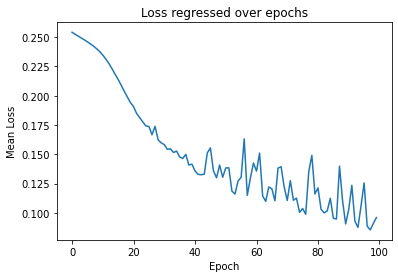

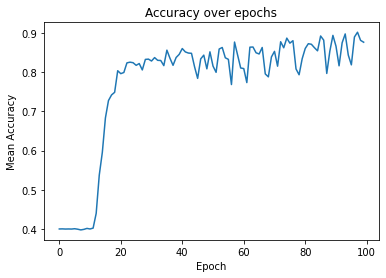

TEST RESULT with dataset  tree_2  imb_level =  0.2 batch_size =  10000


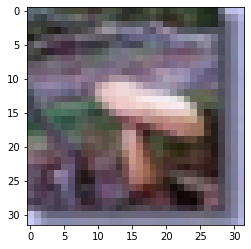

(10000, 32, 32, 3) <class 'numpy.ndarray'>
Shape of X_operator aka X_input:  (100, 32, 32, 3)
Max F1 Score:  0.8536585365853658
ROC-AUC Score:  0.945625


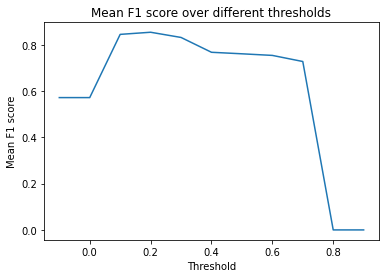

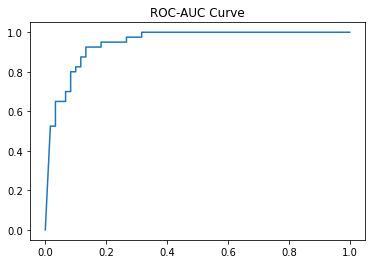

Done!
TRAINING SET'S: 
 Number of instance: 500


100%|██████████| 4/4 [00:00<00:00, 15.91it/s]



TRAIN RESULT with dataset:  tree_2  
imb_level =  0.2 
batch_size =  128  
using loss function:  MSFE  
learning_rate =  0.1 
number of epoch:  100
Balancing Class Weight:  tensor([0.8333, 1.2500])


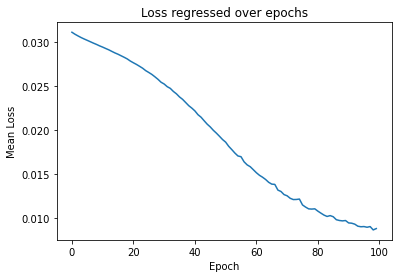

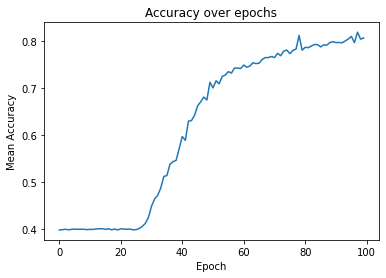

TEST RESULT with dataset  tree_2  imb_level =  0.2 batch_size =  10000


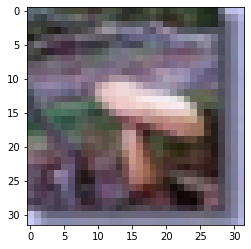

(10000, 32, 32, 3) <class 'numpy.ndarray'>
Shape of X_operator aka X_input:  (100, 32, 32, 3)
Max F1 Score:  0.8311688311688312
ROC-AUC Score:  0.9475


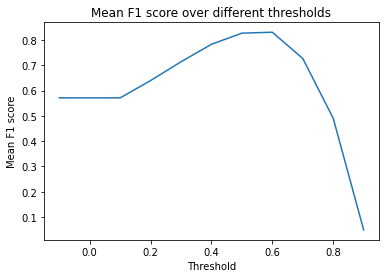

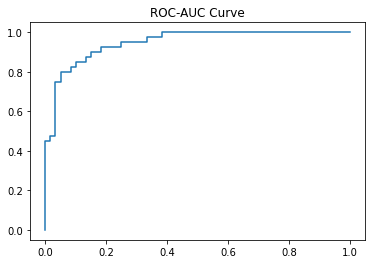

Done!
TRAINING SET'S: 
 Number of instance: 500


100%|██████████| 4/4 [00:00<00:00, 15.92it/s]



TRAIN RESULT with dataset:  tree_2  
imb_level =  0.1 
batch_size =  128  
using loss function:  MFE  
learning_rate =  0.1 
number of epoch:  100
Balancing Class Weight:  tensor([0.6250, 2.5000])


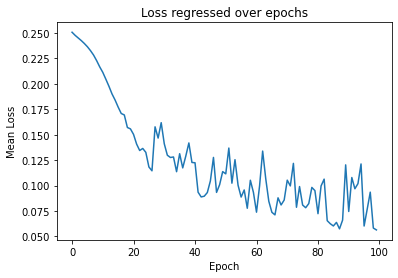

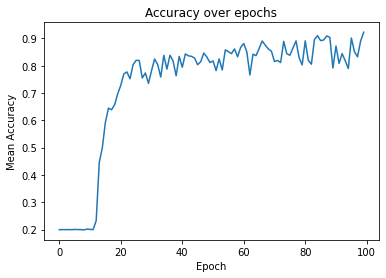

TEST RESULT with dataset  tree_2  imb_level =  0.1 batch_size =  10000


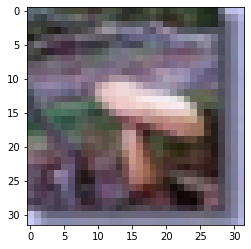

(10000, 32, 32, 3) <class 'numpy.ndarray'>
Shape of X_operator aka X_input:  (100, 32, 32, 3)
Max F1 Score:  0.7441860465116279
ROC-AUC Score:  0.9393750000000001


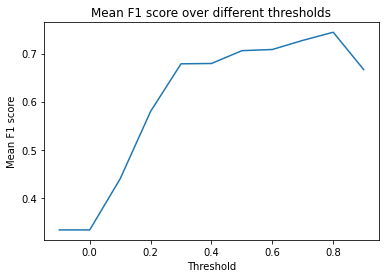

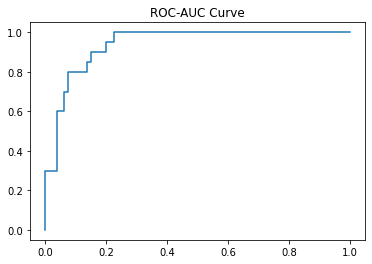

Done!
TRAINING SET'S: 
 Number of instance: 500


100%|██████████| 4/4 [00:00<00:00, 14.99it/s]



TRAIN RESULT with dataset:  tree_2  
imb_level =  0.1 
batch_size =  128  
using loss function:  MSFE  
learning_rate =  0.1 
number of epoch:  100
Balancing Class Weight:  tensor([0.6250, 2.5000])


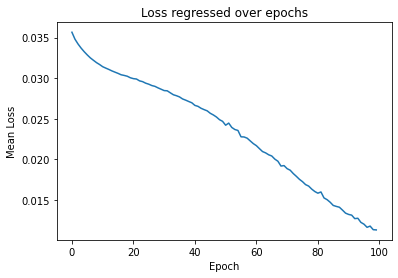

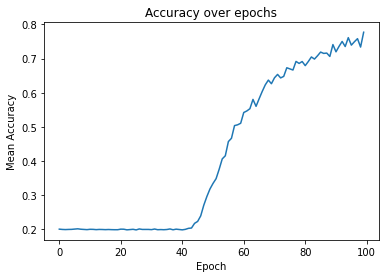

TEST RESULT with dataset  tree_2  imb_level =  0.1 batch_size =  10000


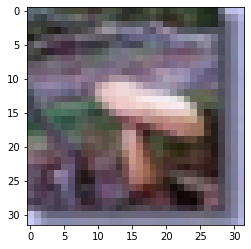

(10000, 32, 32, 3) <class 'numpy.ndarray'>
Shape of X_operator aka X_input:  (100, 32, 32, 3)
Max F1 Score:  0.7272727272727272
ROC-AUC Score:  0.900625


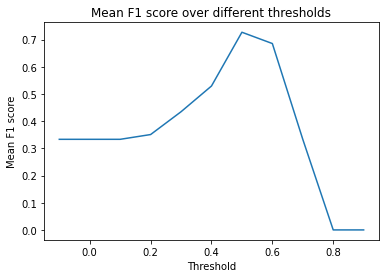

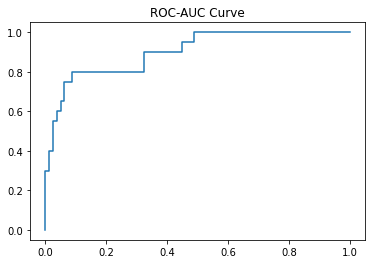

Done!
TRAINING SET'S: 
 Number of instance: 500


100%|██████████| 4/4 [00:00<00:00, 13.80it/s]



TRAIN RESULT with dataset:  tree_2  
imb_level =  0.05 
batch_size =  128  
using loss function:  MFE  
learning_rate =  0.1 
number of epoch:  100
Balancing Class Weight:  tensor([0.5556, 5.0000])


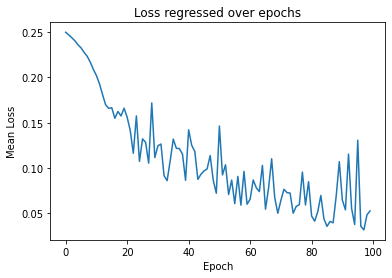

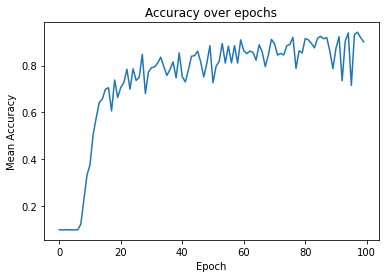

TEST RESULT with dataset  tree_2  imb_level =  0.05 batch_size =  10000


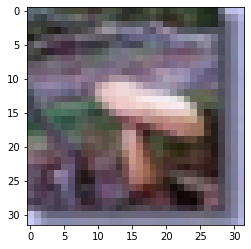

(10000, 32, 32, 3) <class 'numpy.ndarray'>
Shape of X_operator aka X_input:  (100, 32, 32, 3)
Max F1 Score:  0.6666666666666667
ROC-AUC Score:  0.9488888888888889


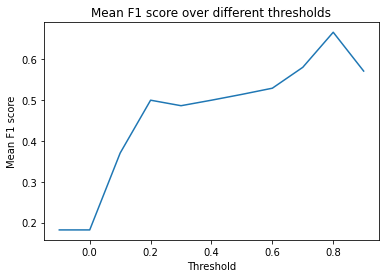

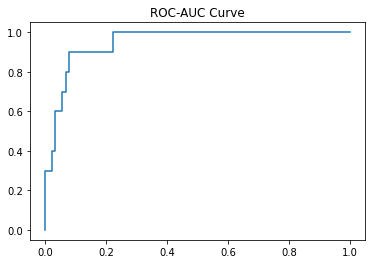

Done!
TRAINING SET'S: 
 Number of instance: 500


100%|██████████| 4/4 [00:00<00:00, 14.13it/s]



TRAIN RESULT with dataset:  tree_2  
imb_level =  0.05 
batch_size =  128  
using loss function:  MSFE  
learning_rate =  0.1 
number of epoch:  100
Balancing Class Weight:  tensor([0.5556, 5.0000])


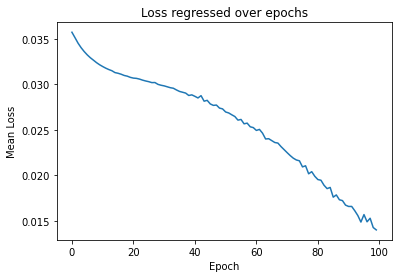

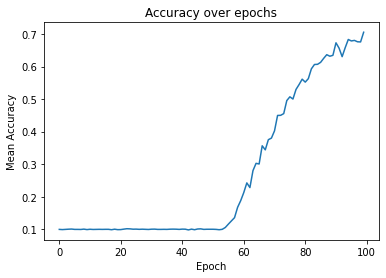

TEST RESULT with dataset  tree_2  imb_level =  0.05 batch_size =  10000


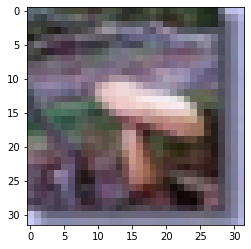

(10000, 32, 32, 3) <class 'numpy.ndarray'>
Shape of X_operator aka X_input:  (100, 32, 32, 3)
Max F1 Score:  0.6666666666666666
ROC-AUC Score:  0.9533333333333334


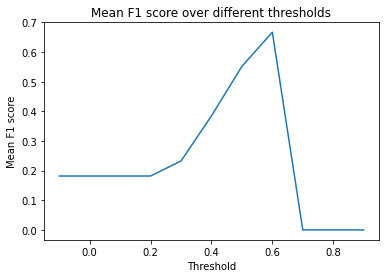

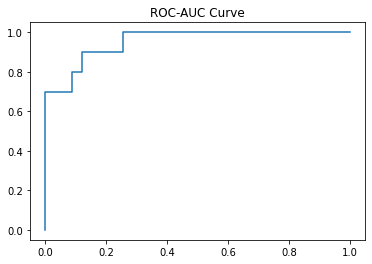

Done!
TRAINING SET'S: 
 Number of instance: 2500


100%|██████████| 20/20 [00:00<00:00, 21.30it/s]



TRAIN RESULT with dataset:  household  
imb_level =  0.2 
batch_size =  128  
using loss function:  MFE  
learning_rate =  0.1 
number of epoch:  100
Balancing Class Weight:  tensor([0.8333, 1.2500])


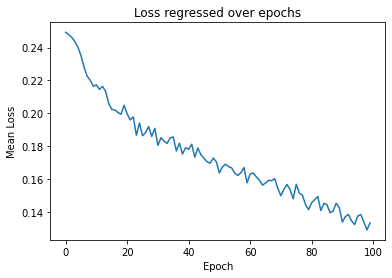

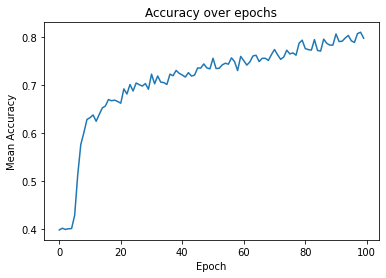

TEST RESULT with dataset  household  imb_level =  0.2 batch_size =  10000


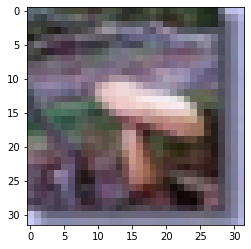

(10000, 32, 32, 3) <class 'numpy.ndarray'>
Shape of X_operator aka X_input:  (500, 32, 32, 3)
Max F1 Score:  0.6816143497757847
ROC-AUC Score:  0.7955666666666668


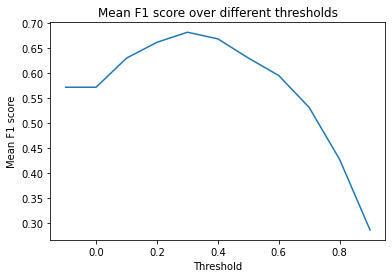

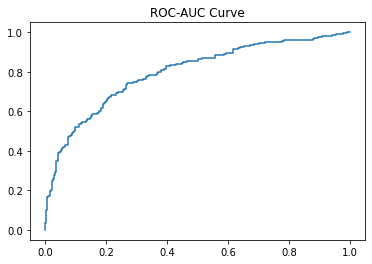

Done!
TRAINING SET'S: 
 Number of instance: 2500


100%|██████████| 20/20 [00:00<00:00, 21.26it/s]



TRAIN RESULT with dataset:  household  
imb_level =  0.2 
batch_size =  128  
using loss function:  MSFE  
learning_rate =  0.1 
number of epoch:  100
Balancing Class Weight:  tensor([0.8333, 1.2500])


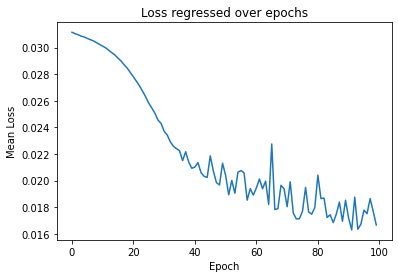

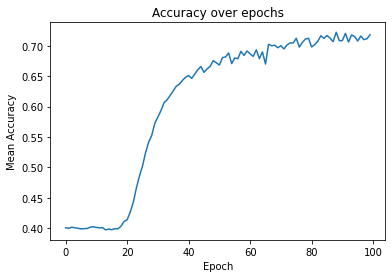

TEST RESULT with dataset  household  imb_level =  0.2 batch_size =  10000


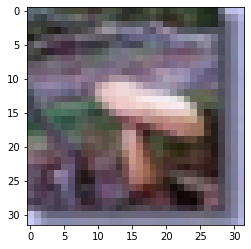

(10000, 32, 32, 3) <class 'numpy.ndarray'>
Shape of X_operator aka X_input:  (500, 32, 32, 3)
Max F1 Score:  0.6463414634146342
ROC-AUC Score:  0.74475


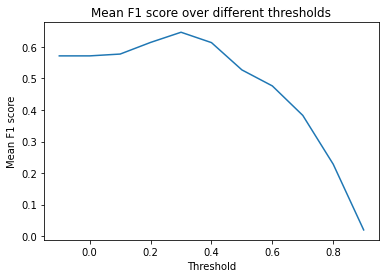

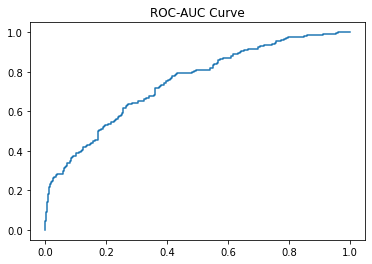

Done!
TRAINING SET'S: 
 Number of instance: 2500


100%|██████████| 20/20 [00:00<00:00, 21.02it/s]



TRAIN RESULT with dataset:  household  
imb_level =  0.1 
batch_size =  128  
using loss function:  MFE  
learning_rate =  0.1 
number of epoch:  100
Balancing Class Weight:  tensor([0.6250, 2.5000])


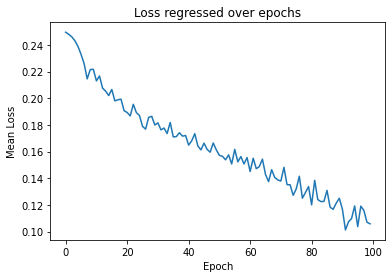

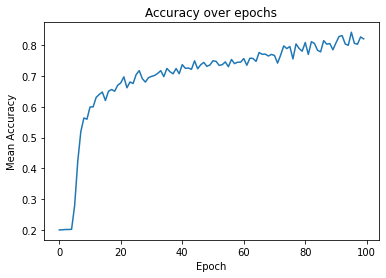

TEST RESULT with dataset  household  imb_level =  0.1 batch_size =  10000


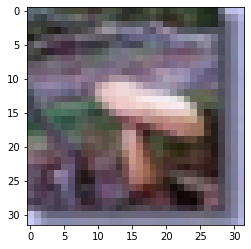

(10000, 32, 32, 3) <class 'numpy.ndarray'>
Shape of X_operator aka X_input:  (500, 32, 32, 3)
Max F1 Score:  0.5390625
ROC-AUC Score:  0.80855


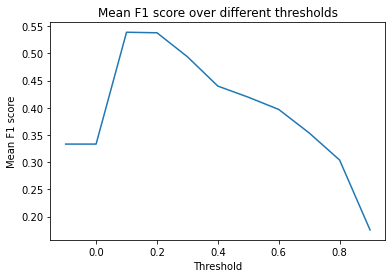

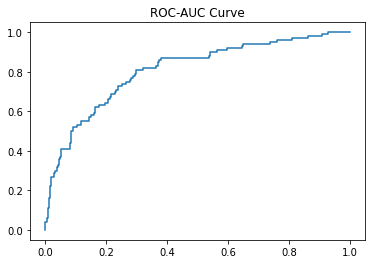

Done!
TRAINING SET'S: 
 Number of instance: 2500


100%|██████████| 20/20 [00:01<00:00, 14.54it/s]



TRAIN RESULT with dataset:  household  
imb_level =  0.1 
batch_size =  128  
using loss function:  MSFE  
learning_rate =  0.1 
number of epoch:  100
Balancing Class Weight:  tensor([0.6250, 2.5000])


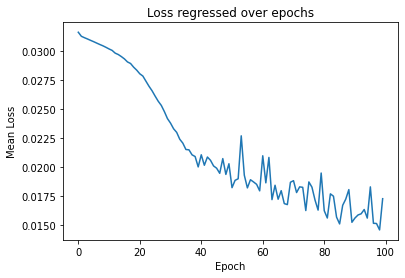

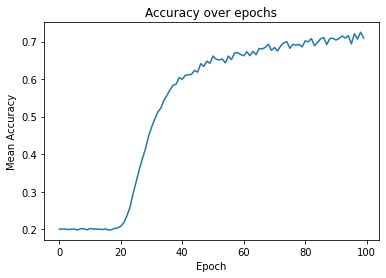

TEST RESULT with dataset  household  imb_level =  0.1 batch_size =  10000


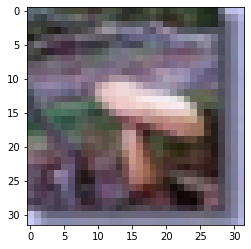

(10000, 32, 32, 3) <class 'numpy.ndarray'>
Shape of X_operator aka X_input:  (500, 32, 32, 3)
Max F1 Score:  0.4342105263157895
ROC-AUC Score:  0.705225


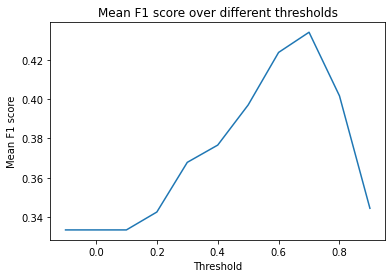

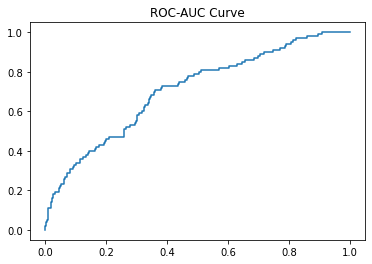

Done!
TRAINING SET'S: 
 Number of instance: 2500


100%|██████████| 20/20 [00:00<00:00, 20.05it/s]



TRAIN RESULT with dataset:  household  
imb_level =  0.05 
batch_size =  128  
using loss function:  MFE  
learning_rate =  0.1 
number of epoch:  100
Balancing Class Weight:  tensor([0.5556, 5.0000])


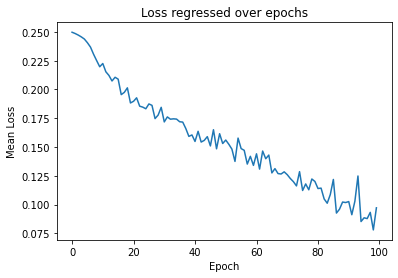

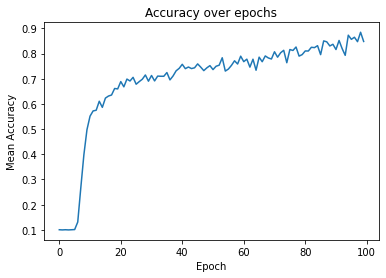

TEST RESULT with dataset  household  imb_level =  0.05 batch_size =  10000


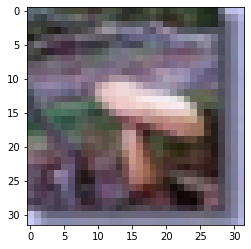

(10000, 32, 32, 3) <class 'numpy.ndarray'>
Shape of X_operator aka X_input:  (500, 32, 32, 3)
Max F1 Score:  0.3963963963963964
ROC-AUC Score:  0.7707111111111112


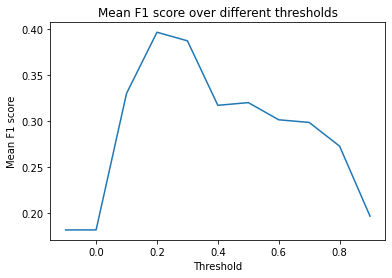

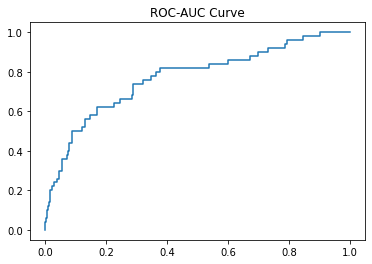

Done!
TRAINING SET'S: 
 Number of instance: 2500


100%|██████████| 20/20 [00:01<00:00, 12.46it/s]



TRAIN RESULT with dataset:  household  
imb_level =  0.05 
batch_size =  128  
using loss function:  MSFE  
learning_rate =  0.1 
number of epoch:  100
Balancing Class Weight:  tensor([0.5556, 5.0000])


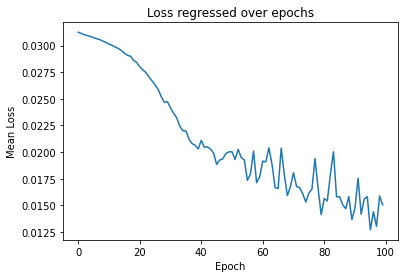

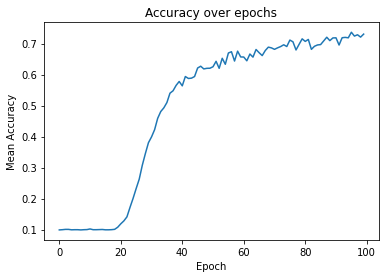

TEST RESULT with dataset  household  imb_level =  0.05 batch_size =  10000


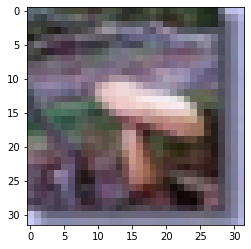

(10000, 32, 32, 3) <class 'numpy.ndarray'>
Shape of X_operator aka X_input:  (500, 32, 32, 3)
Max F1 Score:  0.3625
ROC-AUC Score:  0.7693777777777777


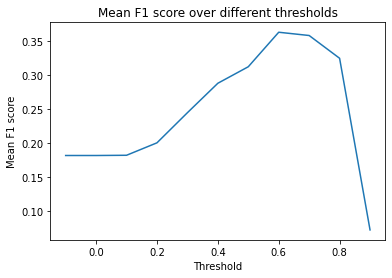

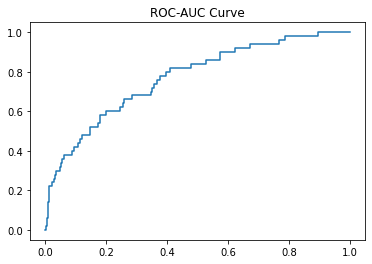

Done!
TRAINING SET'S: 
 Number of instance: 500


100%|██████████| 4/4 [00:00<00:00, 12.75it/s]



TRAIN RESULT with dataset:  tree_1  
imb_level =  0.2 
batch_size =  128  
using loss function:  MFE  
learning_rate =  0.1 
number of epoch:  100
Balancing Class Weight:  tensor([0.8333, 1.2500])


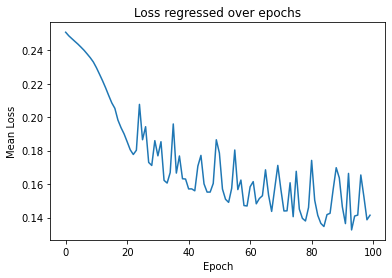

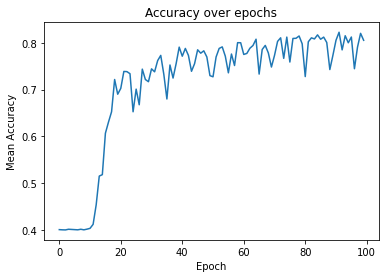

TEST RESULT with dataset  tree_1  imb_level =  0.2 batch_size =  10000


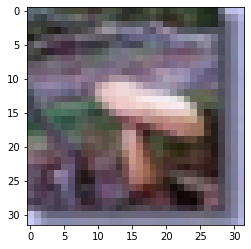

(10000, 32, 32, 3) <class 'numpy.ndarray'>
Shape of X_operator aka X_input:  (100, 32, 32, 3)
Max F1 Score:  0.6666666666666666
ROC-AUC Score:  0.7979166666666666


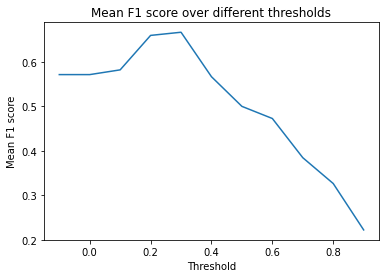

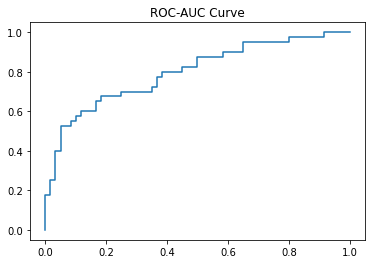

Done!
TRAINING SET'S: 
 Number of instance: 500


100%|██████████| 4/4 [00:00<00:00, 12.21it/s]



TRAIN RESULT with dataset:  tree_1  
imb_level =  0.2 
batch_size =  128  
using loss function:  MSFE  
learning_rate =  0.1 
number of epoch:  100
Balancing Class Weight:  tensor([0.8333, 1.2500])


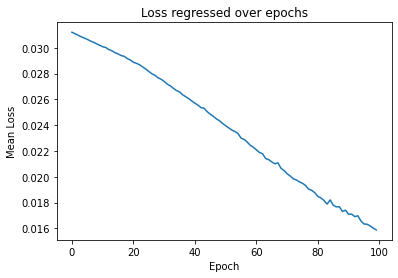

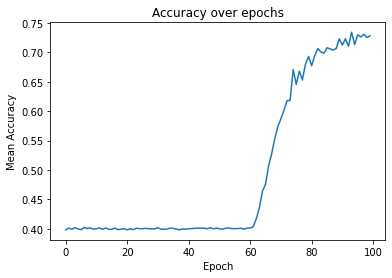

TEST RESULT with dataset  tree_1  imb_level =  0.2 batch_size =  10000


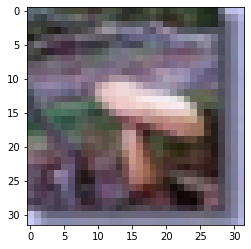

(10000, 32, 32, 3) <class 'numpy.ndarray'>
Shape of X_operator aka X_input:  (100, 32, 32, 3)
Max F1 Score:  0.6938775510204082
ROC-AUC Score:  0.80625


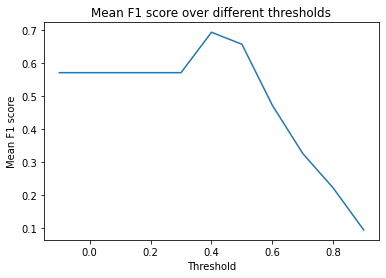

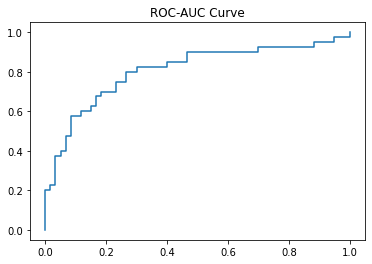

Done!
TRAINING SET'S: 
 Number of instance: 500


100%|██████████| 4/4 [00:00<00:00, 12.68it/s]



TRAIN RESULT with dataset:  tree_1  
imb_level =  0.1 
batch_size =  128  
using loss function:  MFE  
learning_rate =  0.1 
number of epoch:  100
Balancing Class Weight:  tensor([0.6250, 2.5000])


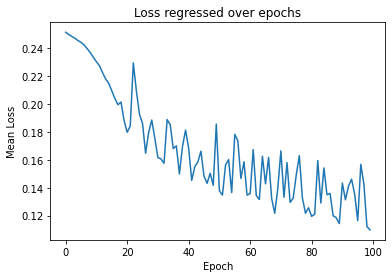

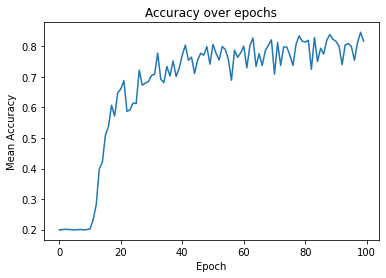

TEST RESULT with dataset  tree_1  imb_level =  0.1 batch_size =  10000


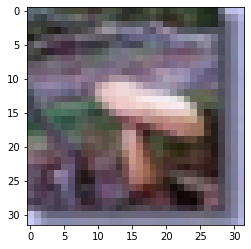

(10000, 32, 32, 3) <class 'numpy.ndarray'>
Shape of X_operator aka X_input:  (100, 32, 32, 3)
Max F1 Score:  0.588235294117647
ROC-AUC Score:  0.814375


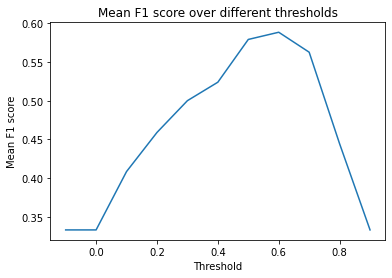

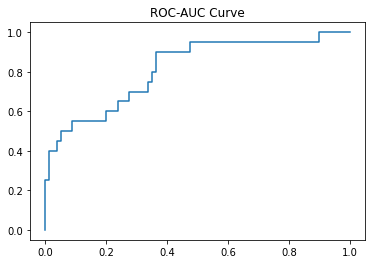

Done!
TRAINING SET'S: 
 Number of instance: 500


100%|██████████| 4/4 [00:00<00:00, 12.99it/s]



TRAIN RESULT with dataset:  tree_1  
imb_level =  0.1 
batch_size =  128  
using loss function:  MSFE  
learning_rate =  0.1 
number of epoch:  100
Balancing Class Weight:  tensor([0.6250, 2.5000])


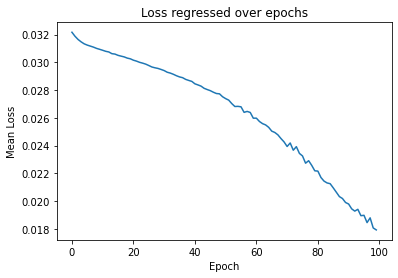

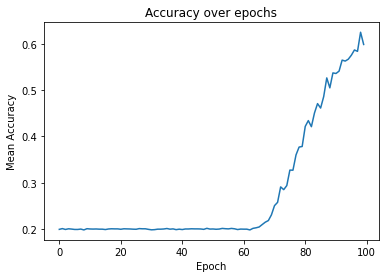

TEST RESULT with dataset  tree_1  imb_level =  0.1 batch_size =  10000


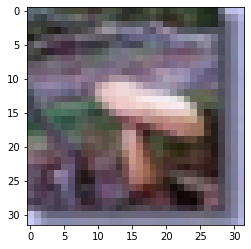

(10000, 32, 32, 3) <class 'numpy.ndarray'>
Shape of X_operator aka X_input:  (100, 32, 32, 3)
Max F1 Score:  0.5652173913043479
ROC-AUC Score:  0.82875


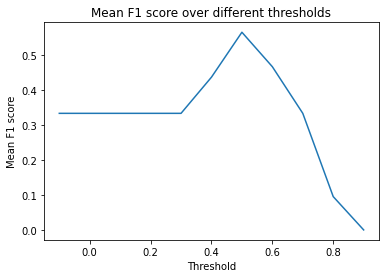

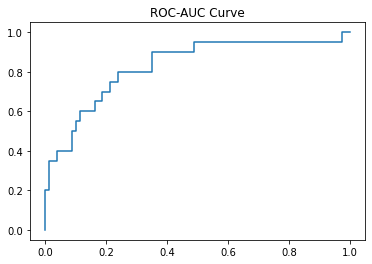

Done!
TRAINING SET'S: 
 Number of instance: 500


100%|██████████| 4/4 [00:00<00:00, 12.59it/s]



TRAIN RESULT with dataset:  tree_1  
imb_level =  0.05 
batch_size =  128  
using loss function:  MFE  
learning_rate =  0.1 
number of epoch:  100
Balancing Class Weight:  tensor([0.5556, 5.0000])


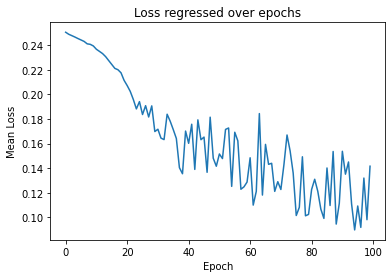

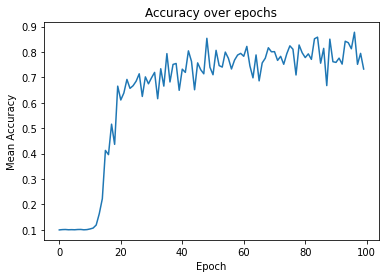

TEST RESULT with dataset  tree_1  imb_level =  0.05 batch_size =  10000


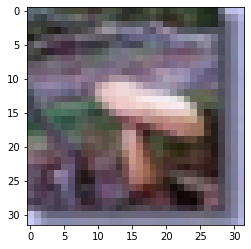

(10000, 32, 32, 3) <class 'numpy.ndarray'>
Shape of X_operator aka X_input:  (100, 32, 32, 3)
Max F1 Score:  0.48275862068965514
ROC-AUC Score:  0.8899999999999999


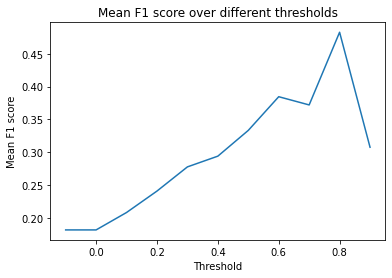

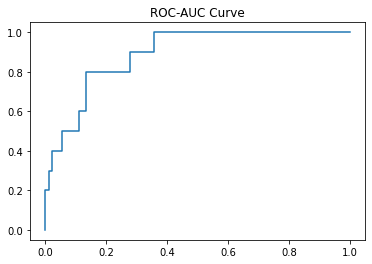

Done!
TRAINING SET'S: 
 Number of instance: 500


100%|██████████| 4/4 [00:00<00:00,  9.41it/s]



TRAIN RESULT with dataset:  tree_1  
imb_level =  0.05 
batch_size =  128  
using loss function:  MSFE  
learning_rate =  0.1 
number of epoch:  100
Balancing Class Weight:  tensor([0.5556, 5.0000])


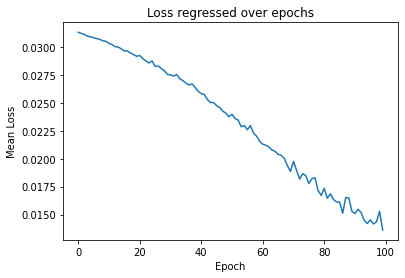

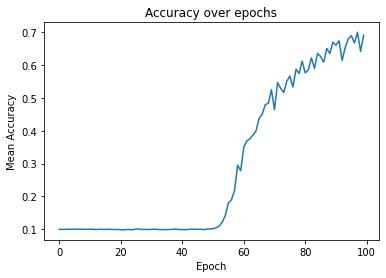

TEST RESULT with dataset  tree_1  imb_level =  0.05 batch_size =  10000


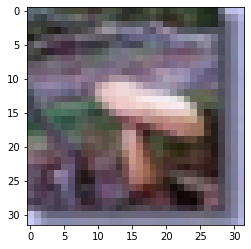

(10000, 32, 32, 3) <class 'numpy.ndarray'>
Shape of X_operator aka X_input:  (100, 32, 32, 3)
Max F1 Score:  0.4444444444444445
ROC-AUC Score:  0.8722222222222222


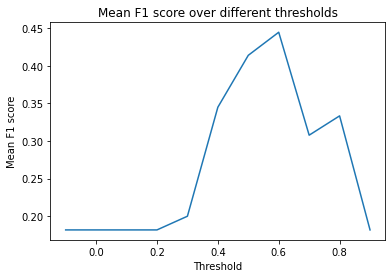

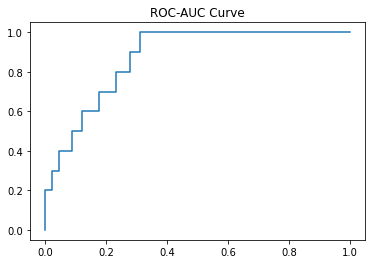

Done!


In [ ]:
REMIND_1 = ["MFE", "MSFE"]
REMIND_2 = [0.2, 0.1, 0.05]
REMIND_3 = ["tree_2","household", "tree_1"]

for dataset_name_gen in REMIND_3:
    for imb_level_gen in REMIND_2:
      for loss_gen in REMIND_1:  
        class_label = train_data[b'fine_labels']
        superclass_label = train_data[b'coarse_labels']
        class_name = meta_data[b'fine_label_names']
        superclass_name = meta_data[b'coarse_label_names']

        model = set_pipeline(X_train, dataset_name = dataset_name_gen, imb_level = imb_level_gen, learning_rate = 0.1, 
                     num_of_epochs = 100, batch_size_train = 128, shuffle_train = True, loss_name = loss_gen)
        
        class_label = test_data[b'fine_labels']
        superclass_label = test_data[b'coarse_labels']
        class_name = meta_data[b'fine_label_names']
        superclass_name = meta_data[b'coarse_label_names']
        
        delete_list = test_phase(X_test, dataset_name = dataset_name_gen, imb_level = imb_level_gen, batch_size = X_test.shape[0])
        
        del delete_list
        del model 
        gc.collect()
